**Le but de ce devoir** est d'utiliser diverses méthodes de traitement d'images apprises au cours du semestre pour isoler le dessin et le texte présents sur l'image « asma.jpg », et ce sous la forme d'un élément unique dépourvu de bruit ou de fond.
 Pour parvenir à ce résultat, une série d'étapes a été suivie : 
 - transformation en niveaux de gris
 - application d'un seuillage
 - filtrage Gaussian
 - manipulations morphologiques (open / close)
 - identification des contours 
 - élaboration du masque final

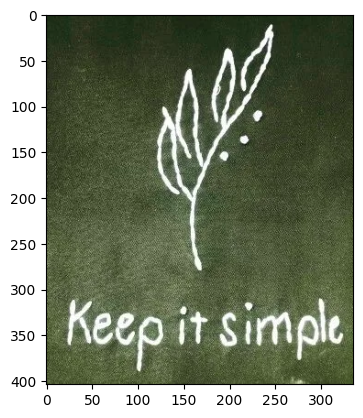

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('asma.jpg')
plt.imshow(img)

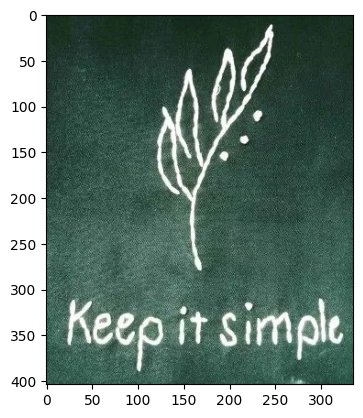

In [ ]:

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

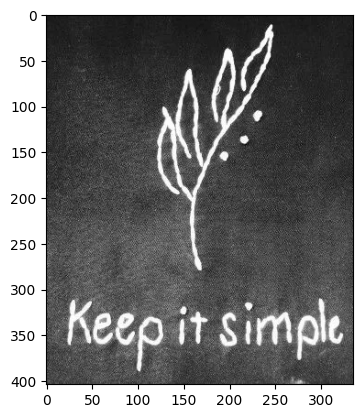

In [ ]:

gray = cv2.imread('asma.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(gray, cmap='gray')

**Seuillage Otsu**

Le seuillage automatique d’Otsu permet de séparer le dessin (blanc) du fond (vert foncé).

Nous utilisons deux méthodes :

**THRESH_BINARY :** les pixels clairs → blanc et sombres → noir.
👉 On l’utilise pour repérer les zones lumineuses du dessin, car la plante et le texte sont blancs à l’origine.

**THRESH_BINARY_INV :** Inverse 
👉 On l’utilise pour détecter les traits fins ou zones sombres autour du dessin, car certains contours peuvent apparaître légèrement assombris après filtrage.

ainsi qu’un seuillage adaptatif pour garantir une meilleure extraction.

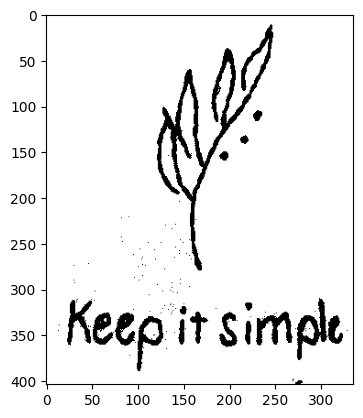

In [ ]:

_, binary1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(binary1, cmap='gray')

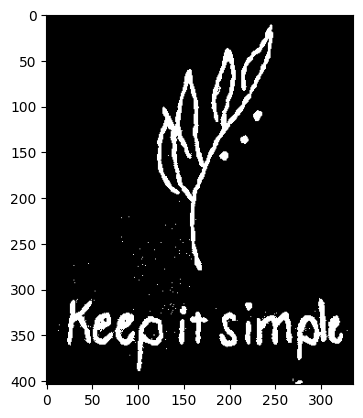

In [ ]:

_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(binary, cmap='gray')

- Un flou gaussien permet de lisser l'image et de réduire le bruit avant le seuillage.

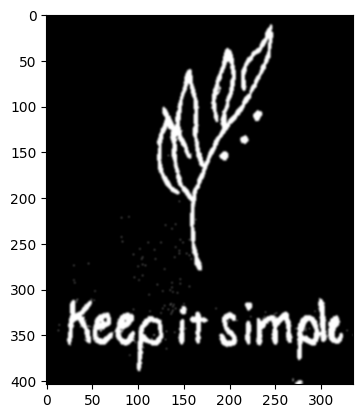

In [ ]:
blur = cv2.GaussianBlur(binary, (5, 5), 0)
plt.imshow(blur, cmap='gray')

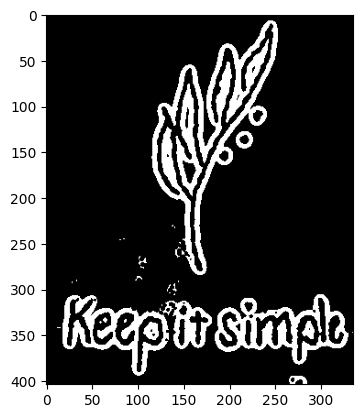

In [ ]:

binary2 = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 5)
plt.imshow(binary2, cmap='gray')

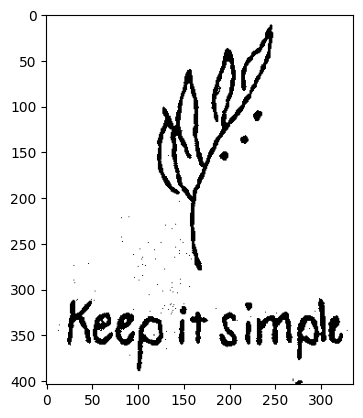

In [ ]:

combined_binary = cv2.bitwise_or(binary1, binary2)
plt.imshow(combined_binary, cmap='gray')

**Opérations morphologiques**
Pour obtenir un masque propre, nous appliquons :

- Ouverture  : élimine les petits points parasites
- Fermeture  : relie entre eux les segments du dessin pour éviter la fragmentation

Le noyau utilisé est petit (1×1 ou 3×3) afin de préserver les détails fins de la plante et de l’écriture.

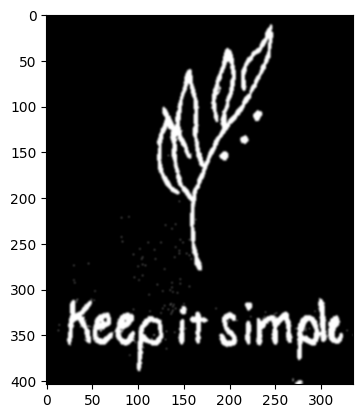

In [ ]:

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))

opened = cv2.morphologyEx(blur, cv2.MORPH_OPEN, kernel)

plt.imshow(opened, cmap='gray')

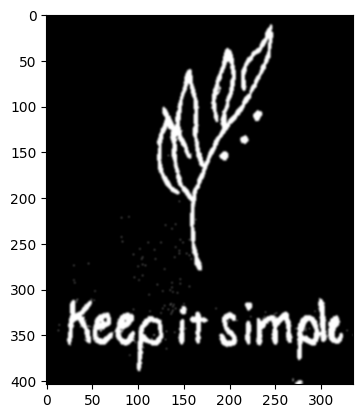

In [ ]:
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed, cmap='gray')

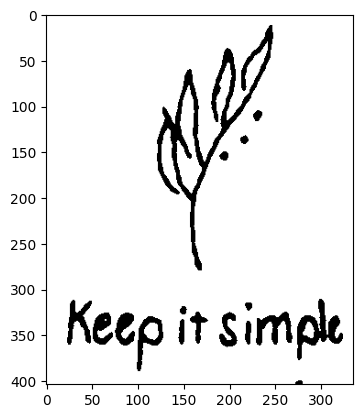

In [ ]:
_, binary3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

opened1 = cv2.morphologyEx(binary3, cv2.MORPH_OPEN, kernel)

plt.imshow(opened1, cmap='gray')


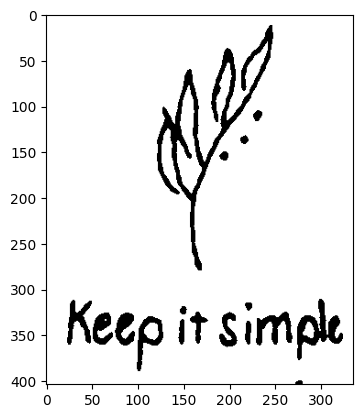

In [ ]:
closed1 = cv2.morphologyEx(opened1, cv2.MORPH_CLOSE, kernel)

plt.imshow(closed1, cmap='gray')

**Détection des contours**
Nous utilisons *cv2.findContours* pour récupérer l’ensemble des formes présentes :

- RETR_LIST permet de conserver tous les contours.

Un filtrage par surface (min_area) est effectué pour éviter d’inclure du bruit.

- Un masque noir est créé et rempli uniquement avec les contours valides.

- Extraction de l’objet :  
   L’objet (plante + texte) est extrait via un AND logique appliqué à l'image originale.

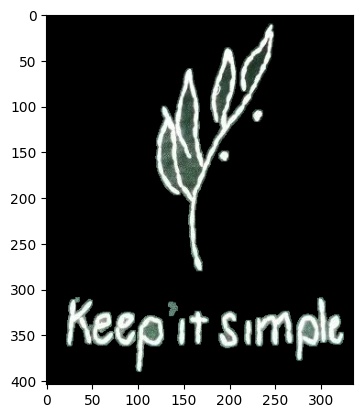

In [ ]:

# contours, hierarchy = cv2.findContours(closed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

edges = cv2.Canny(closed, 50, 150, apertureSize=3, L2gradient=True)
edges = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)))
contours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

min_area = 100  
valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

mask = np.zeros_like(closed)
for cnt in valid_contours:
    cv2.fillPoly(mask, [cnt], 255)

result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
plt.imshow(result)

(np.float64(-0.5), np.float64(335.5), np.float64(403.5), np.float64(-0.5))

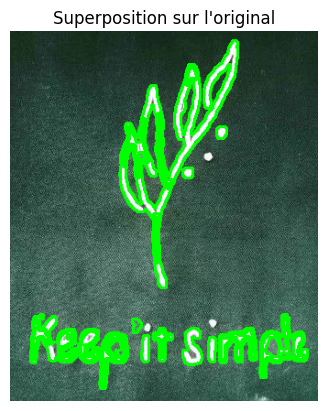

In [ ]:
plt.title("Superposition sur l'original")
overlay = img.copy()
for cnt in valid_contours:
    cv2.drawContours(overlay, [cnt], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')

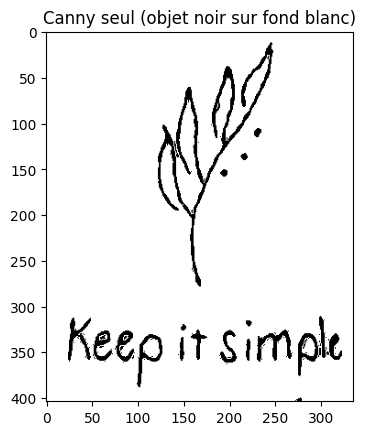

In [ ]:
# Lissage léger
gauss = cv2.GaussianBlur(gray, (5, 5), 0)
gauss1 = cv2.GaussianBlur(binary, (5, 5), 0)

_, binaryG = cv2.threshold(gauss1, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Canny seul
edges = cv2.Canny(gauss, 50, 150)

# Inverser pour obtenir fond blanc + dessin noir
result1 = cv2.bitwise_or(edges , binaryG)

plt.title("Canny seul (objet noir sur fond blanc)")
plt.imshow(result1, cmap='gray')

**Résultats**

Chaque étape est affichée dans une grille :

- image originale
- niveaux de gris
- binaire
- ouverture / fermeture
- masque
- objet extrait
- superposition des contours

Le résultat final montre correctement le dessin complet en un seul morceau, sans le fond.

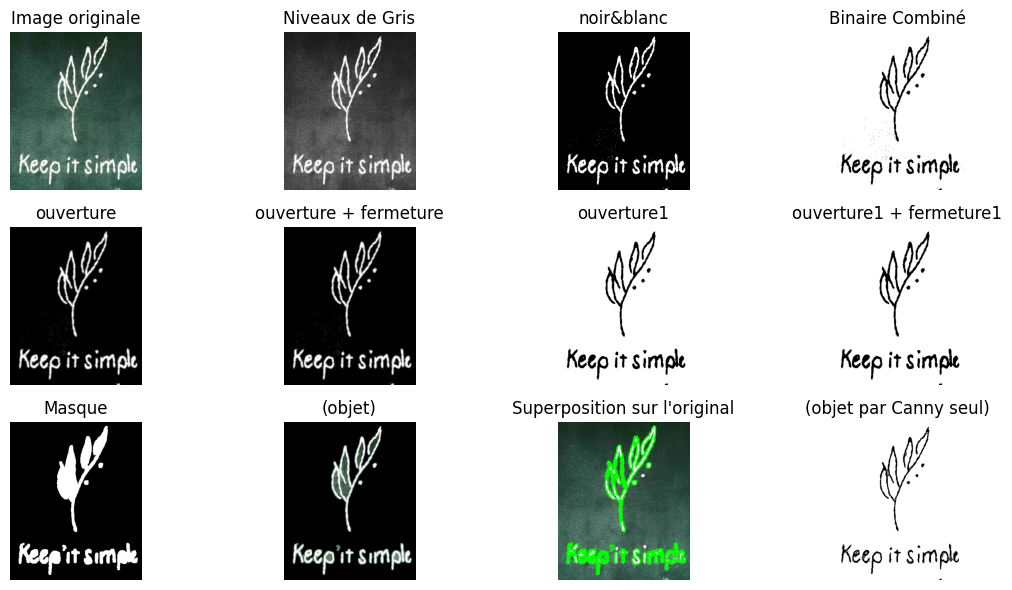

In [ ]:

plt.figure(figsize=(12, 6))

plt.subplot(3, 4, 1)
plt.title("Image originale")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(gray, cmap='gray')
plt.title('Niveaux de Gris')
plt.axis('off')

plt.subplot(3, 4, 3)
plt.title("noir&blanc")
plt.imshow(binary, cmap='gray')
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(combined_binary, cmap='gray')
plt.title('Binaire Combiné')
plt.axis('off')

plt.subplot(3, 4, 5)
plt.title("ouverture")
plt.imshow(opened, cmap='gray')
plt.axis('off')

plt.subplot(3, 4, 6)
plt.title("ouverture + fermeture")
plt.imshow(closed, cmap='gray')
plt.axis('off')

plt.subplot(3, 4, 7)
plt.title("ouverture1")
plt.imshow(opened1, cmap='gray')
plt.axis('off')

plt.subplot(3, 4, 8)
plt.title("ouverture1 + fermeture1")
plt.imshow(closed1, cmap='gray')
plt.axis('off')

plt.subplot(3, 4, 9)
plt.imshow(mask, cmap='gray')
plt.title('Masque')
plt.axis('off')

plt.subplot(3, 4, 10)
plt.title("(objet)")
plt.imshow(result)
plt.axis('off')

plt.subplot(3, 4, 11)
plt.title("Superposition sur l'original")
overlay = img.copy()
for cnt in valid_contours:
    cv2.drawContours(overlay, [cnt], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(3, 4, 12)
plt.title("(objet par Canny seul)")
plt.imshow(result1 , cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
